In [84]:
import numpy as np
from sklearn.cluster import KMeans
from stl import mesh  # You may need to install the 'numpy-stl' library for STL file manipulation
from tqdm import tqdm
import math
import matplotl.lib.pyplot as plt
class Teeth:
    def __init__(self, data, num_cluster):
        self.class_number = num_cluster
        self.data=data
    
    def rotate_teeth(self, angle_degrees):
            # Convert angle to radians
            angle_radians = math.radians(angle_degrees)

            # Define rotation matrix for the Z-axis (assuming teeth are in the XY plane)
            rotation_matrix = np.array([
                [math.cos(angle_radians), -math.sin(angle_radians), 0],
                [math.sin(angle_radians), math.cos(angle_radians), 0],
                [0, 0, 1]
            ])

            # Apply rotation to each point in the teeth data
            self.data = np.dot(self.data, rotation_matrix)

ModuleNotFoundError: No module named 'matplotl'

In [91]:
class Jaw:

    def __init__(self, stl_files, num_teeth,jaw):
        self.stl_files = stl_files
        self.num_teeth=num_teeth
        self.jaw=jaw
        self.dict_teeth_name = {
        'Central Incisor': 0,
        'Lateral Incisor': 1,
        'Canine (Cuspid)': 2,
        'First Premolar (Bicuspid)': 3,
        'Second Premolar (Bicuspid)': 4,
        'First Molar': 5,
        'Second Molar': 6,
        'Third Molar (Wisdom Tooth)': 7,
        'Upper Right Central Incisor': 8,
        'Upper Right Lateral Incisor': 9,
        'Upper Right Canine (Cuspid)': 10,
        'Upper Right First Premolar (Bicuspid)': 11,
        'Upper Right Second Premolar (Bicuspid)': 12,
        'Upper Right First Molar': 13,
        'Upper Right Second Molar': 14,
        'Upper Right Third Molar (Wisdom Tooth)': 15,
        'Upper Left Central Incisor': 16,
        'Upper Left Lateral Incisor': 17,
        'Upper Left Canine (Cuspid)': 18,
        'Upper Left First Premolar (Bicuspid)': 19,
        'Upper Left Second Premolar (Bicuspid)': 20,
        'Upper Left First Molar': 21,
        'Upper Left Second Molar': 22,
        'Upper Left Third Molar (Wisdom Tooth)': 23,
        'Lower Right Central Incisor': 24,
        'Lower Right Lateral Incisor': 25,
        'Lower Right Canine (Cuspid)': 26,
        'Lower Right First Premolar (Bicuspid)': 27,
        'Lower Right Second Premolar (Bicuspid)': 28,
        'Lower Right First Molar': 29,
        'Lower Right Second Molar': 30,
        'Lower Right Third Molar (Wisdom Tooth)': 31,
        'Lower Left Central Incisor': 32,
        'Lower Left Lateral Incisor': 33,
        'Lower Left Canine (Cuspid)': 34,
        'Lower Left First Premolar (Bicuspid)': 35,
        'Lower Left Second Premolar (Bicuspid)': 36,
        'Lower Left First Molar': 37,
        'Lower Left Second Molar': 38,
        'Lower Left Third Molar (Wisdom Tooth)': 39
    }

        self.dict_teeth={"l":{0:32,1:31,2:30,3:29,4:28,5:27,6:26,7:25,8:24,9:23,10:22,11:21,12:20,13:19,14:18,15:17,},
                         "u":{0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10,10:11,11:12,12:13,13:14,14:15,15:16}}
        self.teeth_list = self.load_teeth()
        
    def cluster_teeth(self,mesh_data):
        # Perform clustering on the loaded data
        kmeans = KMeans(n_clusters=self.num_teeth,n_init='auto', random_state=42)
        labels = kmeans.fit_predict(mesh_data)
        return labels,kmeans.cluster_centers_
    
    def get_correct_labels(self,cluster_centers):
        return {i:np.argsort(np.argsort(cluster_centers,axis=0)[:,0])[i] for i in range(len(cluster_centers))}

    def getTeethByIdx(self,idx):
        return self.teeth_list[idx]
    
    def getTeethByName(self,label):
        dentist_nb=self.dict_teeth_name[label]
        idx=np.where(np.array(list(self.dict_teeth[self.jaw].values()))==dentist_nb)[0][0]
        return self.getTeethByIdx(idx)

    def load_teeth(self):
        teeth_list = []
        for stl_file in self.stl_files:
            mesh_data = mesh.Mesh.from_file(stl_file).vectors.reshape(-1, 3)
            self.labels,cluster_centers=self.cluster_teeth(mesh_data)
            corrected_labels=self.get_correct_labels(cluster_centers)
            self.labels=[corrected_labels[label] for label in self.labels]
            # Get data points for each label
            clustered_data = {}
            for label in np.unique(self.labels):
                points_in_cluster = mesh_data[self.labels == label]
                #print("labels ",self.labels)
                #print("points:",points_in_cluster)
                clustered_data[label] = points_in_cluster

            # Print or use the clustered data
            for label, points in clustered_data.items():
                teeth_instance = Teeth(points, self.dict_teeth[self.jaw][label])
                teeth_list.append(teeth_instance)
        return teeth_list
    
    def align_teeth(self):
        # Find the lowest point for each teeth instance
        lowest_points = [np.min(teeth_instance.data[:, 2]) for teeth_instance in self.teeth_list]

        # Find the global minimum (lowest point among all teeth)
        global_min = np.min(lowest_points)

        # Adjust the position of each teeth to align with the global minimum
        for i, teeth_instance in enumerate(self.teeth_list):
            offset = global_min - lowest_points[i]
            teeth_instance.data[:, 2] += offset
          
    def compute_distances_and_depths(self,distances=[]):
        # Assuming specific indices for the canine, second premolar, and first molar
        # Replace these indices with the actual indices of your teeth clusters
        res=[]
        for elements in distances:
            if type(elements)==list:
                teeth_1=self.getTeethByName(elements[0])
                teeth_2=self.getTeethByName(elements[1])
                res.append(np.linalg.norm(teeth_1.data - teeth_2.data))
            elif type(elements)==str:
                if elements.__contains__('canine') or elements.__contains__('premolar') or elements.__contains__('first_molar'):
                    teeth_1=self.getTeethByName(elements[0])
                    res.append(np.max(teeth_1.data[:,2]) - np.min(teeth_1.data[:,2]))
        return res
    
    def print_summary(self):
        print("Jaw Summary:")
        print("-" * 40)
        print(f"Number of Teeth: {len(self.teeth_list)}")
        print()

        for i, teeth_instance in enumerate(self.teeth_list):
            print(f"Teeth {i + 1} Summary:")
            print(f"  Class Number: {teeth_instance.class_number}")
            print(f"  Data Shape: {teeth_instance.data.shape}")
            print()

    def plot(self):
        fig = plt.figure()
        data=jaw_instance.getTeethByIdx(0).data
        ax = fig.add_subplot(projection='3d')
        for teeth in self.teeth_list:
            data=teeth.data
            ax.scatter(data[:,0], data[:,1], data[:,2])
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        plt.show()

# Example Usage:
# Provide a list of paths to your STL files and the desired number of clusters
stl_files = [r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_l.stl"]
#r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_u.stl"]
num_clusters = 16

# Create Jaw object
jaw_instance = Jaw(stl_files, num_clusters,'l')
jaw_instance.print_summary()


Jaw Summary:
----------------------------------------
Number of Teeth: 16

Teeth 1 Summary:
  Class Number: 32
  Data Shape: (35064, 3)

Teeth 2 Summary:
  Class Number: 31
  Data Shape: (28929, 3)

Teeth 3 Summary:
  Class Number: 30
  Data Shape: (31226, 3)

Teeth 4 Summary:
  Class Number: 29
  Data Shape: (31378, 3)

Teeth 5 Summary:
  Class Number: 28
  Data Shape: (44738, 3)

Teeth 6 Summary:
  Class Number: 27
  Data Shape: (44190, 3)

Teeth 7 Summary:
  Class Number: 26
  Data Shape: (22872, 3)

Teeth 8 Summary:
  Class Number: 25
  Data Shape: (41775, 3)

Teeth 9 Summary:
  Class Number: 24
  Data Shape: (1279, 3)

Teeth 10 Summary:
  Class Number: 23
  Data Shape: (41937, 3)

Teeth 11 Summary:
  Class Number: 22
  Data Shape: (21006, 3)

Teeth 12 Summary:
  Class Number: 21
  Data Shape: (43771, 3)

Teeth 13 Summary:
  Class Number: 20
  Data Shape: (47492, 3)

Teeth 14 Summary:
  Class Number: 19
  Data Shape: (46495, 3)

Teeth 15 Summary:
  Class Number: 18
  Data Shape: (3

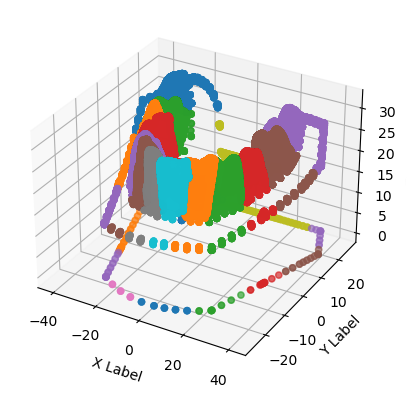

In [92]:
jaw_instance.plot()